## Notebook Purpose

Initial experiments with ConvDecoder, based upon the original notebook `ConvDecoder_vs_DIP_vs_DD_multicoil.ipynb`.

In [2]:
import os, sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5, load_output, save_output, \
                            expmt_already_generated
from utils.transform import np_to_tt, split_complex_vals, recon_ksp_to_img
from utils.helpers import num_params, get_masks
from include.decoder_conv import init_convdecoder
from include.mri_helpers import get_scale_factor, get_masked_measurements, \
                                data_consistency
from include.fit import fit
from utils.evaluate import calc_metrics

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(1)
else:
    dtype = torch.FloatTensor

In [3]:
## UNCOMMENT for half precision and INJECT before fitting network
# net = net.half()
# ksp_masked = ksp_masked.half()
# img_masked = img_masked.half()
# mask = mask.half()
# dtype=torch.cuda.HalfTensor

### Run expmts

In [20]:
img_dc_list, img_est_list, img_gt_list = [], [], []
mse_wrt_ksp_list, mse_wrt_img_list = [], []
ssim_list, psnr_list = [], []

file_id_list = ['1000273', '1000325', '1000464']#, '1000007', '1000537', '1000818', \
                #'1001140', '1001219', '1001338', '1001598', '1001533', '1001798']
# NUM_ITER_LIST = [100, 1000, 10000]
NUM_ITER = 100
ALPHA_LIST = [0, 0.875]# 0.25, 0.5, 0.625, 0.75, 0.875]
# ALPHA = 0
DC_STEP = True

for idx, file_id in enumerate(file_id_list):  
    
    f, slice_ksp = load_h5(file_id) # load full mri measurements
    print('file_id: {}'.format(file_id))
    
    mask, mask2d, mask1d = get_masks(f, slice_ksp) # load mask + variants, M
    mask1d_ = torch.from_numpy(np.array(mask1d, dtype=np.uint8)) # for dc step
    
#     for NUM_ITER in NUM_ITER_LIST:
    for ALPHA in ALPHA_LIST:
            
        # initialize net, net input seed, and scale slice_ksp accordingly
        net, net_input, slice_ksp = init_convdecoder(slice_ksp, mask)
        img_gt = recon_ksp_to_img(slice_ksp) # must do this after slice_ksp is scaled
        img_gt_list.append(img_gt) # could do this once per loop
        
        if expmt_already_generated(file_id, NUM_ITER, DC_STEP, ALPHA):     
            img_dc, mse_wrt_ksp, mse_wrt_img = \
                load_output(file_id, NUM_ITER, DC_STEP, ALPHA)
            img_dc_list.append(img_dc)
            mse_wrt_ksp_list.append(mse_wrt_ksp)
            mse_wrt_img_list.append(mse_wrt_img)
#             img_dc_list.append(load_output(file_id, NUM_ITER, DC_STEP, ALPHA))
            continue

        # for dc step - must do this after scaling slice_ksp
        ksp_orig = np_to_tt(split_complex_vals(slice_ksp))[None, :].type(dtype) #[1,15,640,368,2]

        # apply mask to measurements for fitting model
        ksp_masked, img_masked = get_masked_measurements(slice_ksp, mask)

        net, mse_wrt_ksp, mse_wrt_img = fit(
            ksp_masked=ksp_masked, img_masked=img_masked,
            net=net, net_input=net_input, mask2d=mask2d,
            mask1d=mask1d_, ksp_orig=ksp_orig, DC_STEP=DC_STEP, alpha=ALPHA,
            img_ls=None, num_iter=NUM_ITER, dtype=dtype)

        img_out = net(net_input.type(dtype))[0] # estimate image \hat{x} = G(\hat{C})

        img_dc, _ = data_consistency(img_out, slice_ksp, mask1d)
        save_output(img_dc, mse_wrt_ksp, mse_wrt_img, \
                    file_id, NUM_ITER, DC_STEP, ALPHA)

        # save images, metrics
        img_dc_list.append(img_dc)
        mse_wrt_ksp_list.append(mse_wrt_ksp)
        mse_wrt_img_list.append(mse_wrt_img)
        
for idx_ in range(len(img_dc_list)):
    _, _, ssim_, psnr_ = calc_metrics(img_dc_list[idx_], img_gt_list[idx_])
    ssim_list.append(ssim_)
    psnr_list.append(psnr_)

file_id: 1000273
/bmrNAS/people/dvv/out/1000273_iter100_alpha0.npy already generated
/bmrNAS/people/dvv/out/1000273_iter100_alpha0.875.npy already generated
file_id: 1000325
/bmrNAS/people/dvv/out/1000325_iter100_alpha0.npy already generated
/bmrNAS/people/dvv/out/1000325_iter100_alpha0.875.npy already generated
file_id: 1000464
/bmrNAS/people/dvv/out/1000464_iter100_alpha0.npy already generated
/bmrNAS/people/dvv/out/1000464_iter100_alpha0.875.npy already generated


### Plot loss over iterations (mse_wrt_ksp or mse_wrt_img)

In [22]:
LIST_OI = ALPHA_LIST # or NUM_ITER_LIST, i.e. dimn of comparison
NUM_VARIANTS = len(LIST_OI) # number of different param sets for conv_decoder

0.02793509140610695
0.018603265285491943
0.016723981127142906
0.01932135410606861
0.02375243976712227
0.030328327789902687


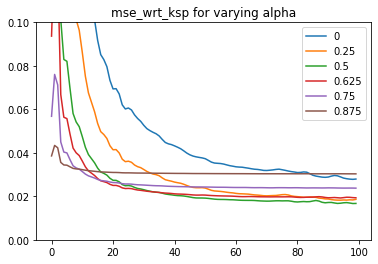

0.05430498719215393
0.03763975575566292
0.04075375944375992
0.04959956184029579
0.06357274204492569
0.08273544162511826


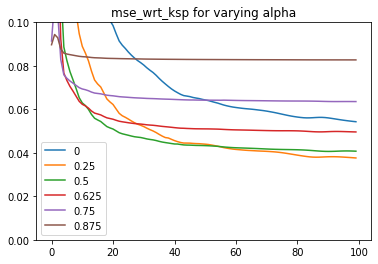

0.012646082788705826
0.007463028188794851
0.005746066104620695
0.005871871020644903
0.006708893459290266
0.008270996622741222


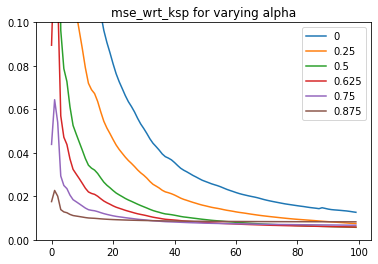

In [18]:
mse_list = mse_wrt_ksp_list

for idx_im in range(len(file_id_list)): # for each img in expmt
    for idx_var in range(NUM_VARIANTS):
        print(mse_list[NUM_VARIANTS*idx_im+idx_var][-1])
        label = str(LIST_OI[idx_var]) # file_id_list[idx_im] # 
        plt.plot(mse_list[NUM_VARIANTS*idx_im+idx_var], label=label)
    plt.ylim(0,0.1)
    plt.title('mse_wrt_ksp for varying alpha')
    plt.legend()
    plt.show()

### Compare ssim, psnr

In [19]:
DEC = 3 # number of decimals to display

# print average across different NUM_VARIANTS
for idx_var in range(NUM_VARIANTS):
    
    psnr_ = psnr_list[idx_var::NUM_VARIANTS] 
    ssim_ = ssim_list[idx_var::NUM_VARIANTS]
    print('ALPHA {}: psnr ~N({}, {}), ssim ~N({}, {})'.format(\
            LIST_OI[idx_var], np.round(np.mean(psnr_), DEC), \
            np.round(np.std(psnr_), DEC), np.round(np.mean(ssim_), DEC), \
            np.round(np.std(ssim_), DEC)))
print('')
    
#print for each sample
for idx_im in range(len(file_id_list)):    
    print('file_id {}'.format(file_id_list[idx_im]))
    for idx_var in range(NUM_VARIANTS):       
        ssim_ = ssim_list[NUM_VARIANTS*idx_im+idx_var]
        psnr_ = psnr_list[NUM_VARIANTS*idx_im+idx_var]
        print('ALPHA {}: {}, {}'.format(LIST_OI[idx_var], \
              np.round(ssim_, DEC), np.round(psnr_, DEC)))            
    print('')

ALPHA 0: psnr ~N(28.14, 0.938), ssim ~N(0.716, 0.061)
ALPHA 0.25: psnr ~N(28.008, 0.928), ssim ~N(0.714, 0.061)
ALPHA 0.5: psnr ~N(28.112, 0.901), ssim ~N(0.716, 0.06)
ALPHA 0.625: psnr ~N(28.035, 0.907), ssim ~N(0.714, 0.06)
ALPHA 0.75: psnr ~N(28.005, 0.927), ssim ~N(0.713, 0.061)
ALPHA 0.875: psnr ~N(28.127, 0.964), ssim ~N(0.716, 0.062)

file_id 1000273
ALPHA 0: 0.709, 28.185
ALPHA 0.25: 0.703, 27.841
ALPHA 0.5: 0.707, 28.079
ALPHA 0.625: 0.702, 27.827
ALPHA 0.75: 0.703, 27.832
ALPHA 0.875: 0.707, 28.047

file_id 1000325
ALPHA 0: 0.645, 26.969
ALPHA 0.25: 0.645, 26.963
ALPHA 0.5: 0.647, 27.025
ALPHA 0.625: 0.647, 27.041
ALPHA 0.75: 0.645, 26.966
ALPHA 0.875: 0.645, 26.989

file_id 1000464
ALPHA 0: 0.794, 29.266
ALPHA 0.25: 0.793, 29.219
ALPHA 0.5: 0.794, 29.232
ALPHA 0.625: 0.794, 29.235
ALPHA 0.75: 0.793, 29.216
ALPHA 0.875: 0.795, 29.345



### Display, save images

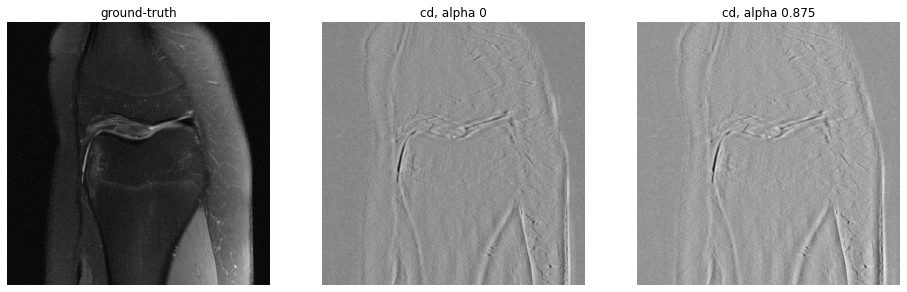

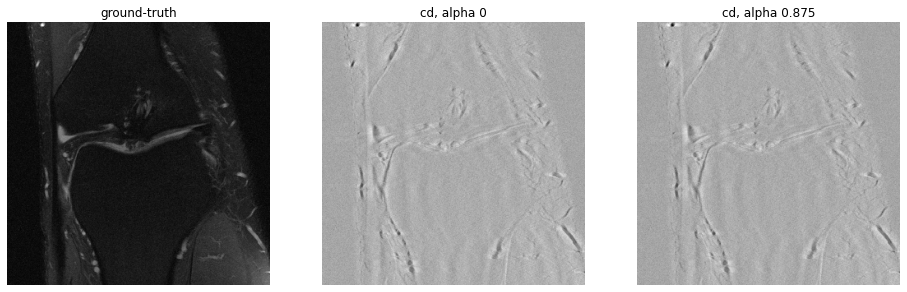

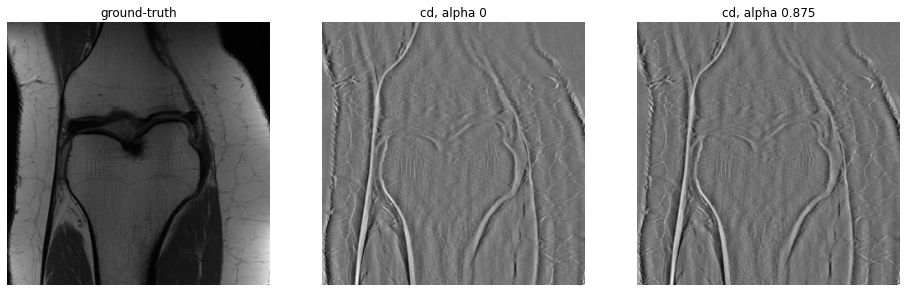

In [23]:
NUM_BASELINES = 1 # i.e. img_gt
NUM_COLS = NUM_VARIANTS + NUM_BASELINES # also want to plot img_gt

DIFF = True

for idx_im in range(len(file_id_list)): # for each img in expmt
    
    fig = plt.figure(figsize=(16, 8))

    # plot gt
    ax = fig.add_subplot(1,NUM_COLS,1)
    img_gt = img_gt_list[NUM_VARIANTS*idx_im]
    ax.imshow(img_gt, cmap='gray')
    ax.set_title('ground-truth')
    ax.axis('off')
    
    for idx_var in range(NUM_VARIANTS):
        ax = fig.add_subplot(1,NUM_COLS,idx_var+NUM_BASELINES+1)
        img_oi = img_dc_list[NUM_VARIANTS*idx_im+idx_var]
        
        if DIFF:
            ax.imshow(img_oi-img_gt, cmap='gray')
        else:
            ax.imshow(img_oi, cmap='gray')
            
        ax.set_title('cd, alpha {}'.format(str(LIST_OI[idx_var])))
        ax.axis('off')
    
#     plt.savefig('plot_output/{}.pdf'.format(file_id_list[idx_im]), format='pdf')
    plt.show()

### Display images, diff(dc_100_iter, dc_10k_iter)

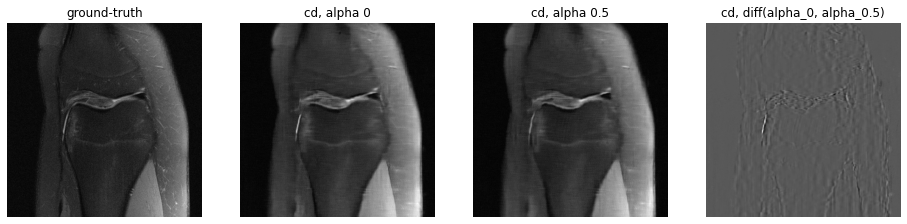

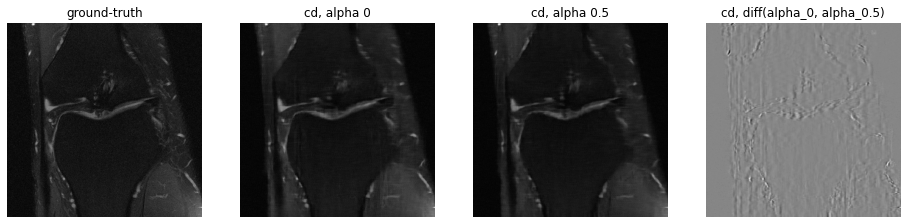

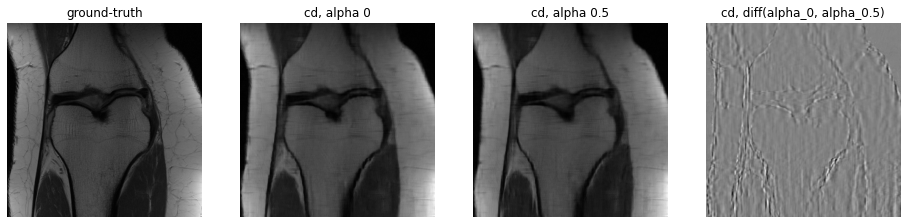

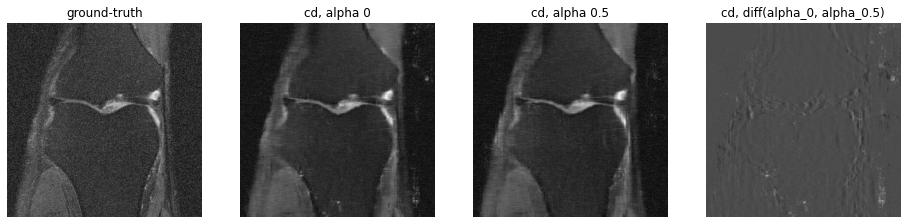

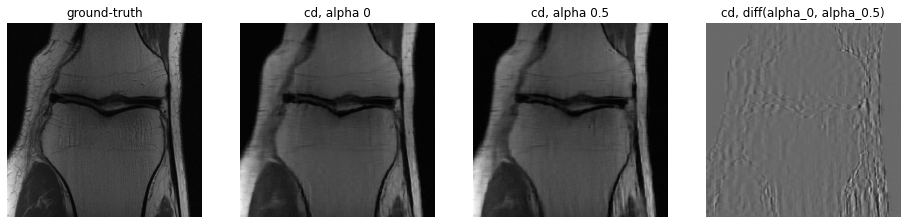

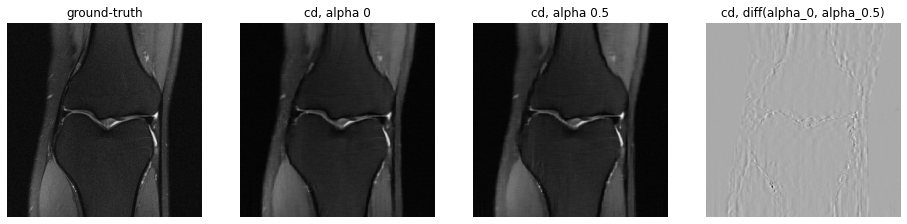

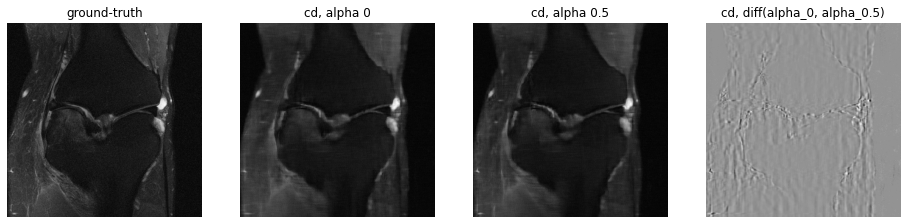

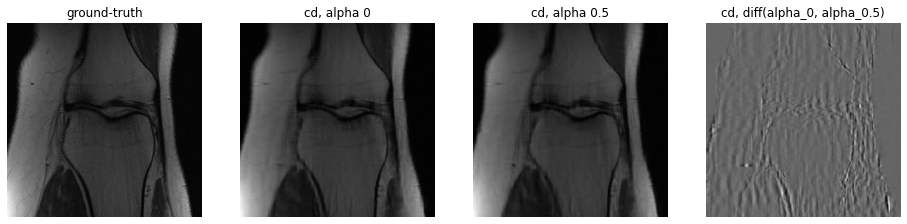

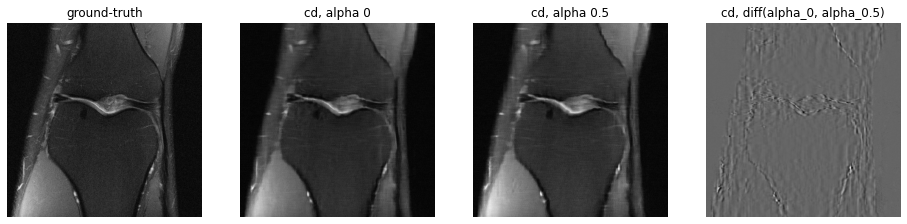

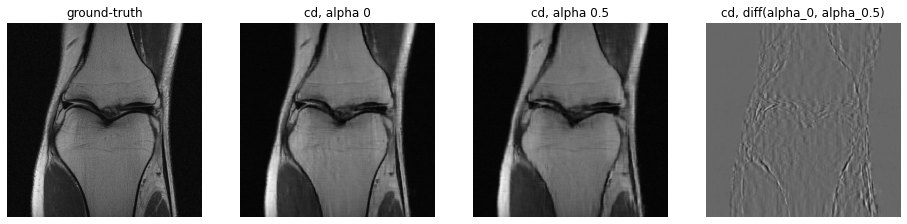

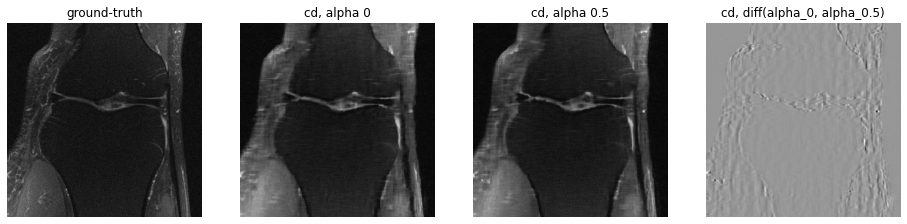

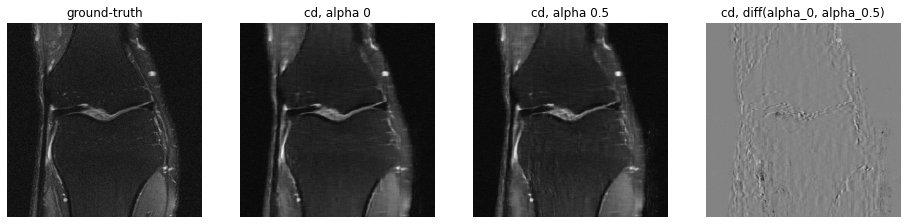

In [55]:
for idx_im in range(len(file_id_list)): # for each img in expmt
    
    fig = plt.figure(figsize=(16, 8))

    # plot gt
    ax = fig.add_subplot(1,NUM_COLS,1)
    img_gt = img_gt_list[NUM_VARIANTS*idx_im]
    ax.imshow(img_gt, cmap='gray')
    ax.set_title('ground-truth')
    ax.axis('off')
    
    for idx_var in range(NUM_VARIANTS):
        
        if idx_var == 0:
            img_100 = img_dc_list[NUM_VARIANTS*idx_im+idx_var]
            ax = fig.add_subplot(1,NUM_COLS,idx_var+NUM_BASELINES+1)
            ax.imshow(img_100, cmap='gray')
            ax.set_title('cd, alpha {}'.format(str(LIST_OI[idx_var])))
            ax.axis('off')
            continue
        elif idx_var == 1:
            OFFSET = 1 # want to get img at next idx_var=2
            img_10k = img_dc_list[NUM_VARIANTS*idx_im+idx_var+OFFSET]
            ax = fig.add_subplot(1,NUM_COLS,idx_var+NUM_BASELINES+1)
            ax.imshow(img_10k, cmap='gray')
            ax.set_title('cd, alpha {}'.format(str(LIST_OI[idx_var+OFFSET])))
            ax.axis('off')
            continue
        elif idx_var == 2: # in last column, plot diff
            ax = fig.add_subplot(1,NUM_COLS,idx_var+NUM_BASELINES+1)
            ax.imshow(img_100-img_10k, cmap='gray')
            ax.set_title('cd, diff(alpha_0, alpha_0.5)')
            ax.axis('off')
    
#     plt.savefig('plot_output/{}.pdf'.format(file_id_list[idx_im]), format='pdf')
    plt.show()

In [ ]:
img_gt_shifted = img_gt * (img_dc.mean() / img_gt.mean())

# est is output image without data consistency step
plt.hist(img_est.flatten(), bins=100, alpha=0.5, label='est')
plt.hist(img_dc.flatten(), bins=100, alpha=0.5, label='dc')
plt.hist(img_gt.flatten(), bins=100, alpha=0.5, label='gt')
plt.legend()
plt.show()